![Minivan](https://i.ytimg.com/vi/cRnlnKiUcNw/maxresdefault.jpg)

# INTRO
### Учебный проект Skillfactory №7 Ford vs. Ferrari: oпределяем модель по фото
**Цель проекта:** Обучить нейронную сеть, которая классифицирует модель автомобиля по фотографии.

**Задачи:**
* Научиться использовать предобученные сети, адаптировать их под свои задачи.
* Подробнее изучить различные архитектуры, как более старые так и SOTA.
* Выбрать оптимизатор, learning rate, loss, размер картинки, батч. Изучить различные техники управления learning rate
* Использовать transfer learning, подобрать архитектуру головы.
* Использовать файнтюнинг.
* Настроить callback-функции
* Научиться аугментировать датасет, в т.ч. с помощью продвинутых техник.
* Настроить логгирование экспериментов (связка mlflow + databricks)

# IMPORT

In [1]:
!pip install mlflow #library that helps to log runs and model parameters

     |████████████████████████████████| 14.1 MB 6.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 15.7 MB/s eta 0:00:01
     |████████████████████████████████| 339 kB 17.0 MB/s eta 0:00:01
     |████████████████████████████████| 125 kB 16.3 MB/s eta 0:00:01
     |████████████████████████████████| 54 kB 2.5 MB/s  eta 0:00:01
     |████████████████████████████████| 77 kB 4.2 MB/s  eta 0:00:01
     |████████████████████████████████| 85 kB 3.1 MB/s  eta 0:00:01
     |████████████████████████████████| 45 kB 2.5 MB/s  eta 0:00:01


  Created wheel for alembic: filename=alembic-1.4.1-py2.py3-none-any.whl size=158154 sha256=9fe77785db39b6f5ec368d1853ba254c7c229099bf67de924b5264f17bc15c95
  Stored in directory: /root/.cache/pip/wheels/be/5d/0a/9e13f53f4f5dfb67cd8d245bb7cdffe12f135846f491a283e3
  Created wheel for databricks-cli: filename=databricks_cli-0.14.1-py3-none-any.whl size=100576 sha256=9f6e88901e3ad402f19c82208fb191bdb164da210a40a692b2d67812dfd3236f
  Stored in directory: /root/.cache/pip/wheels/7f/d9/25/baefac3eda0e7dbf143008d2b9865e0d923d4b7306136244fe
  Created wheel for prometheus-flask-exporter: filename=prometheus_flask_exporter-0.18.1-py3-none-any.whl size=17157 sha256=6c62bd196d161cbcf376d2a82de3506a0577d2fd18e7d695ff994a578c8236a5
  Stored in directory: /root/.cache/pip/wheels/c4/b6/b5/e76659f3b2a3a226565e27f0a7eb7a3ac93c3f4d68acfbe617
Successfully built alembic databricks-cli prometheus-flask-exporter
  Attempting uninstall: alembic
    Found existing installation: alembic 1.4.3
    Uninstalling a

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os

import mlflow #for logging ml runs 
import mlflow.tensorflow

import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.callbacks as C
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers as O
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB4

from tensorflow.keras.layers import *

from sklearn.model_selection import train_test_split, StratifiedKFold

import optuna #for learning rate and optimizer chose

import PIL #image downloading and 
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("../input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['pretrained', 'stanford-car-dataset-by-classes-folder', 'model-8', 'best-pretrained', 'sf-dl-car-classification', 'previous-iteration-model']
Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.17.5
Tensorflow   : 2.3.1
Keras        : 2.4.0


In [3]:
!nvidia-smi #check gpu

Sun Feb  7 18:08:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Setup and helpers

In [4]:
EPOCHS               = 100 # training epochs, let it learn until EarlyStopping criteria is not reached
BATCH_SIZE           = 16 # to be reduced if GPU is not enough
LR                   = 1e-4
VAL_SPLIT            = 0.15 # 15% on test

CLASS_NUM            = 10  
IMG_SIZE             = 380 #image size IMG_SIZExIMG_SIZE
IMG_CHANNELS         = 3   # RGB 
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)
RANDOM_SEED          = 42
# mlflow.tensorflow.autolog() # autologging ML runs

DATA_PATH = '../input/sf-dl-car-classification/'
PATH = "./" # working directory

# optimizers
adadelta = O.Adadelta(learning_rate = LR)
adam = O.Adam(learning_rate = LR)
adagrad = O.Adagrad(learning_rate = LR)
rmsprop = O.RMSprop(learning_rate = LR)

checkpoint =  C.ModelCheckpoint('best_model.hdf5' , monitor = 'val_accuracy' , verbose = 1  , mode = 'max', save_best_only=True)
# scheduler = LearningRateScheduler(get_triangular_lr)
callback_reduce_lr = C.ReduceLROnPlateau(monitor='val_loss', # descending learning rate policy
                                       factor=0.5,
                                       min_lr=1e-10,
                                       patience=0,
                                       verbose=1)
early_stopping_callback = C.EarlyStopping(  # early stopping if val_loss is not decreasing after 5 epochs
    monitor="val_loss",
    patience=5,
    verbose=0,
    restore_best_weights=True)


callbacks_list = [early_stopping_callback, checkpoint, callback_reduce_lr]

In [5]:
def get_history(history):
    """Plotting validation loss and accuracy changing history"""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
 
    epochs = range(len(acc))
 
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
 
    plt.figure()
 
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
 
    plt.show()
    
def show_ctgs(train_df, h):
    """Function that shows 2 random images of each category"""
    for i in range(0,h):
        labels = list(train_df[train_df.Category == i].Id)
        ix = random.randint(0, len(labels))
        image = PIL.Image.open(PATH+f'train/{i}/{labels[ix]}')
        axarr[i,0].set(title = f'Категория {i}')
        axarr[i,0].imshow(image)
        
        ix = random.randint(0, len(labels))
        image = PIL.Image.open(PATH+f'train/{i}/{labels[ix]}')
        axarr[i,1].set(title = f'Категория {i}')
        axarr[i,1].imshow(image)


In [6]:
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-j8n4nosj
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=29530 sha256=dbaa1ed6d132e5c86b151ff058f98fa5209b6c79debab9908504e90a4b4b2bc2
  Stored in directory: /tmp/pip-ephem-wheel-cache-p9vx6q9h/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [7]:
# Data augmentations setup

from ImageDataAugmentor.image_data_augmentor import *
import albumentations

AUGMENTATIONS = albumentations.Compose([
    albumentations.Transpose(p=0.5),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=1),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.OneOf([albumentations.PadIfNeeded(IMG_SIZE, IMG_SIZE, border_mode=0, value=0),
    albumentations.Resize(height=IMG_SIZE, width=IMG_SIZE)])
])

# Pre-training data of Stanford Cars Dataset

Для того чтобы расширить выборку, я решил попробовать сначала потюнить модель предобученную на imagenet на стэнфордском датасете из восьми тысяч изображений автомобилей (+аугментация) со 196 классами, затем заменить голову модели и продолжить на датасете соревнования. Так же необходимо подобрать архитектуру новой головы модели и понять, нужно ли замораживать слои обученные на cars196.

Настроим загрузку и аугментацию данных cars196

In [8]:
#pre_training setup
data_path = '../input/stanford-car-dataset-by-classes-folder'
nb_train_samples = 8144
nb_validation_samples = 8041
n_classes = 196

In [9]:
import csv
names = []

with open(data_path + '/names.csv') as csvDataFile:
    csvReader = csv.reader(csvDataFile, delimiter=';')
    for row in csvReader:
        names.append(row[0])

print(names[:10])

['AM General Hummer SUV 2000', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012', 'Acura Integra Type R 2001', 'Acura ZDX Hatchback 2012', 'Aston Martin V8 Vantage Convertible 2012', 'Aston Martin V8 Vantage Coupe 2012', 'Aston Martin Virage Convertible 2012']


In [10]:
#Pre-training data loaders
train_data_dir = data_path + '/car_data/car_data/train'
test_data_dir = data_path + '/car_data/car_data/test'


train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment=AUGMENTATIONS,
        validation_split=VAL_SPLIT,
        preprocess_input=None)

train_gen = train_datagen.flow_from_directory(
    train_data_dir,      # pictures' directory
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_gen = train_datagen.flow_from_directory(
    test_data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:332: UserWarning: Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` '


Found 7018 images belonging to 196 classes.
Found 1116 images belonging to 196 classes.


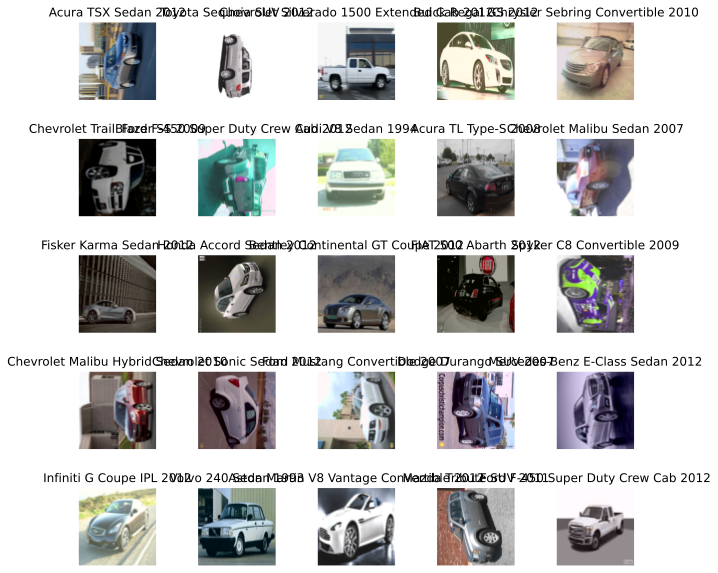

In [11]:
train_gen.show_data()

# Data

Загружаем данные соревнования

In [12]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [14]:
print(train_df.Category.value_counts())
print(f'There are {train_df.Category.nunique()} unique categories')

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64
There are 10 unique categories


In [15]:
print('Unpacking pictures')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile(DATA_PATH+data_zip,"r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

Unpacking pictures
['__notebook_source__.ipynb', 'train', 'test_upload']


Покажем по два автомобиля из каждой категории, чтобы лучше понять, что эти категории означают.

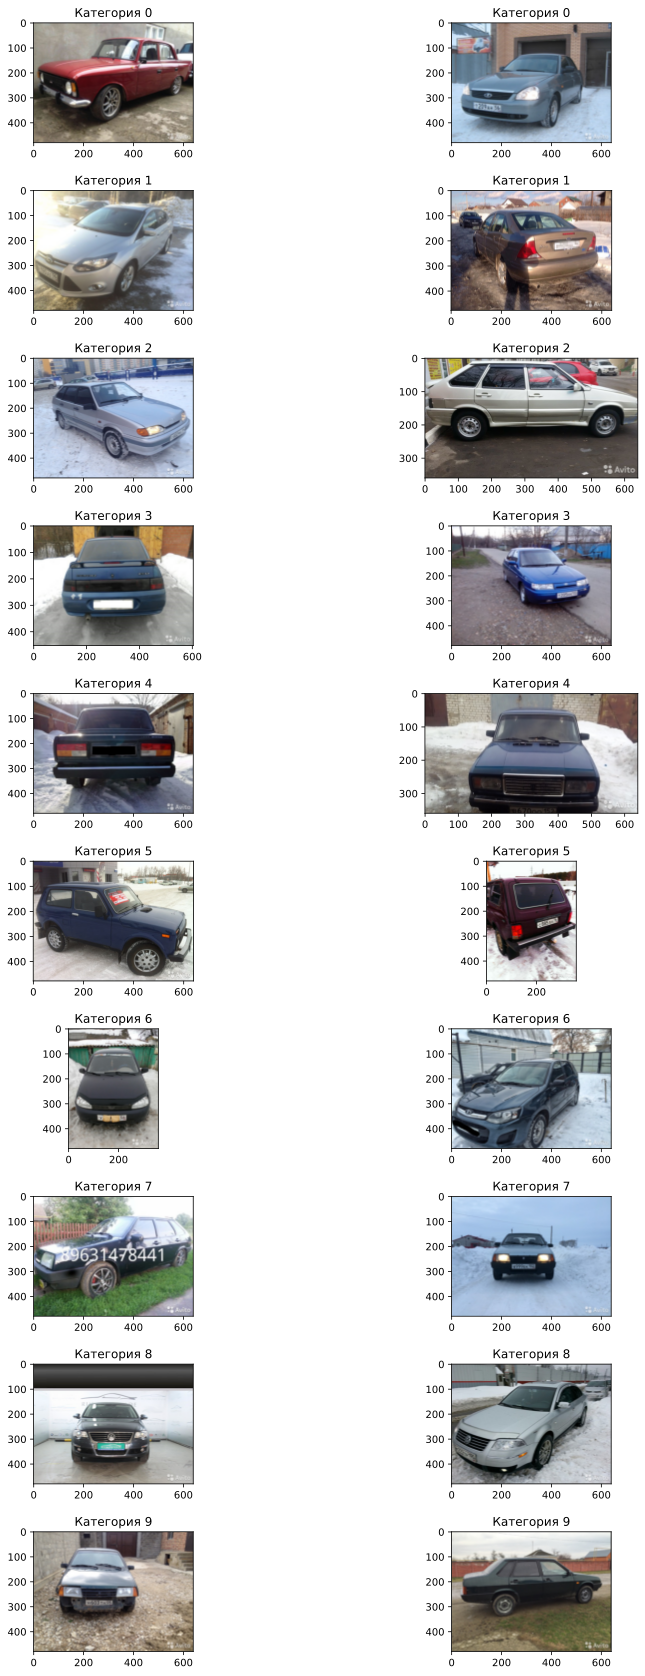

In [16]:
h,w = 10,2
fig, axarr = plt.subplots(nrows=h, ncols=w, gridspec_kw={'wspace':0, 'hspace':0.4}, figsize=(15,30))


show_ctgs(train_df, h)

Не разбираюсь в автомобилях, но похоже на разные модели жигулей :)

# Data Generators
Создадим генераторы с использованием либы albumentations для аугментации данных.

In [17]:
# dataloaders
train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment=AUGMENTATIONS,
        validation_split=VAL_SPLIT,
        preprocess_input=None)

test_datagen = ImageDataAugmentor(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # pictures directory
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

aug_sub_generator =  train_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)


/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:332: UserWarning: Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` '


Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.
Found 6675 validated image filenames.


/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:455: UserWarning: Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` '


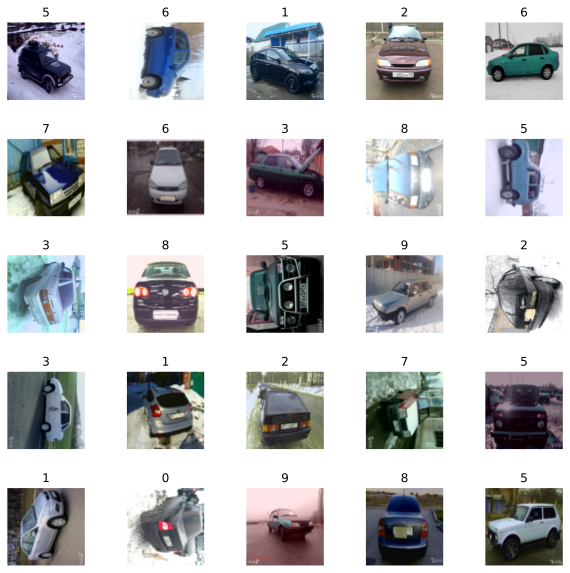

In [18]:
train_generator.show_data()

# Base model training and transfer learning

In [129]:
def pretrain_model():
    """Function for base model pretraining on the cars196 dataset"""
    base = EfficientNetB4(include_top=False, weights='imagenet', input_shape=input_shape)

    # new head installation
    x = base.output
    
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    # and a logistic layer
    predictions = Dense(n_classes, activation='softmax')(x)

    # this is the base model we will train
    model = Model(inputs=base.input, outputs=predictions)
    # model.load_weights('./best_model.hdf5') # строка используется для дообучения при повторном прогоне, чтобы не делать последовательные ноутбуки, а менять настройки
    model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])
    history = model.fit_generator(
        train_gen,
        steps_per_epoch = len(train_gen),
        validation_data = test_gen, 
        validation_steps = len(test_gen),
        epochs = EPOCHS,
        callbacks = callbacks_list)
    model.save('../working/model_last.hdf5')
    return model

In [131]:
with mlflow.start_run():
#    base_model = pretrain_model() #training on the larger dataset (cars196)
    base_model.load_weights('./best_model.hdf5')
    
    # Installing new softmax layer on the base model
    model = K.Sequential([Model(inputs = base_model.inputs,
                         outputs = base_model.layers[-2].output),
                        Dense(10,'softmax')])
    model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])
    history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list)

Epoch 1/100
827/827 [==============================] - ETA: 0s - loss: 3.1547 - accuracy: 0.1112
Epoch 00001: val_accuracy did not improve from 0.74731
827/827 [==============================] - 659s 797ms/step - loss: 3.1547 - accuracy: 0.1112 - val_loss: 2.9160 - val_accuracy: 0.1172
Epoch 2/100
827/827 [==============================] - ETA: 0s - loss: 3.1122 - accuracy: 0.1196
Epoch 00002: val_accuracy did not improve from 0.74731
827/827 [==============================] - 656s 793ms/step - loss: 3.1122 - accuracy: 0.1196 - val_loss: 2.8543 - val_accuracy: 0.1241
Epoch 3/100
827/827 [==============================] - ETA: 0s - loss: 3.0829 - accuracy: 0.1262
Epoch 00003: val_accuracy did not improve from 0.74731
827/827 [==============================] - 660s 798ms/step - loss: 3.0829 - accuracy: 0.1262 - val_loss: 2.8489 - val_accuracy: 0.1331
Epoch 4/100
716/827 [========================>.....] - ETA: 1:23 - loss: 3.0580 - accuracy: 0.1267

KeyboardInterrupt: 

# ML

In [ ]:
# for layer in model.layers[0]: #freezing base model
#     layer.trainable = False

In [ ]:
# # Cyclic learning rate from scratch (TO BE FIXED)
# num_iterations = 10000
# stepsize = 1000
# base_lr = 0.00001
# max_lr = 0.001
# lr_trend = list()
# # Используем циклический learning rate
# def get_triangular_lr(epoch, base_lr, stepsize = stepsize, max_lr = max_lr):
#     """Given the inputs, calculates the lr that should be applicable for this iteration"""
#     cycle = np.floor(1 + iteration/(2  * stepsize))
#     x = np.abs(iteration/stepsize - 2 * cycle + 1)
#     lr = base_lr + (max_lr - base_lr) * np.maximum(0, (1-x))
#     return lr



# # Посмотрим как именно меняется lr
# for iteration in range(num_iterations):
#     lr = get_triangular_lr(iteration, base_lr, stepsize,  max_lr)
#     # Update your optimizer to use this learning rate in this iteration
#     lr_trend.append(lr)

# plt.plot(lr_trend)

In [ ]:
# history = model.fit_generator(
#         train_generator,
#         steps_per_epoch = len(train_generator),
#         validation_data = test_generator, 
#         validation_steps = len(test_generator),
#         epochs = EPOCHS,
#         callbacks = callbacks_list
# )

In [20]:
base_model = tf.keras.models.load_model('../input/model-8/model_last(1).hdf5')
base_model.load_weights('../input/model-8/best_model(8).hdf5')
    
# Installing new softmax layer on the base model
model = K.Sequential([Model(inputs = base_model.inputs,
                         outputs = base_model.layers[-2].output),
                        Dense(10,'softmax')])
model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list)

Epoch 1/100
827/827 [==============================] - ETA: 0s - loss: 0.6204 - accuracy: 0.7945
Epoch 00001: val_accuracy improved from -inf to 0.69601, saving model to best_model.hdf5
827/827 [==============================] - 670s 810ms/step - loss: 0.6204 - accuracy: 0.7945 - val_loss: 0.9416 - val_accuracy: 0.6960
Epoch 2/100
827/827 [==============================] - ETA: 0s - loss: 0.2758 - accuracy: 0.9056
Epoch 00002: val_accuracy improved from 0.69601 to 0.76900, saving model to best_model.hdf5
827/827 [==============================] - 665s 804ms/step - loss: 0.2758 - accuracy: 0.9056 - val_loss: 0.7311 - val_accuracy: 0.7690
Epoch 3/100
827/827 [==============================] - ETA: 0s - loss: 0.1897 - accuracy: 0.9362
Epoch 00003: val_accuracy improved from 0.76900 to 0.88622, saving model to best_model.hdf5
827/827 [==============================] - 666s 805ms/step - loss: 0.1897 - accuracy: 0.9362 - val_loss: 0.3614 - val_accuracy: 0.8862
Epoch 4/100
827/827 [==========

In [21]:
# saving final model and loading the best weights
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [22]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

146/146 [==============================] - 30s 203ms/step - loss: 0.1506 - accuracy: 0.9609
Accuracy: 96.09%


# Submission

In [23]:
#Clean
test_sub_generator.samples

6675

In [24]:
test_sub_generator.reset()
predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

418/418 [==============================] - 71s 170ms/step


In [25]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

Save submit


In [26]:
from tqdm import tqdm

In [ ]:
#test time augmentation
tta_steps = 20
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(aug_sub_generator, steps=len(aug_sub_generator), verbose = 1)
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

predictions = np.argmax(pred, axis=-1)

filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('tta_submission.csv', index=False)
print('Save submit')

  0%|          | 0/20 [00:00<?, ?it/s]

418/418 [==============================] - 92s 219ms/step


  5%|▌         | 1/20 [01:32<29:08, 92.02s/it]

418/418 [==============================] - 91s 217ms/step


 10%|█         | 2/20 [03:03<27:31, 91.72s/it]

418/418 [==============================] - 91s 217ms/step


 15%|█▌        | 3/20 [04:34<25:55, 91.52s/it]

 39/418 [=>............................] - ETA: 1:22

In [ ]:
predictions

# Feature Visualization

В качестве эксперимента попробуем визуализировать на что реагируют фичи в базовой модели.

In [ ]:
#Feature maps visualization
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

img = load_img(PATH+'/train/0/100380.jpg', target_size = (IMG_SIZE,IMG_SIZE))
imgplot = plt.imshow(img)
plt.show()
img.size

img = img_to_array(img)
img.shape

In [ ]:
from numpy import expand_dims

img = expand_dims(img, axis=0)
feature_maps = model.predict(img)

square = 8
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(feature_maps[0,:], cmap='gray')
        ix += 1
# show the figure
plt.show()

In [ ]:
feature_maps[0].shape

In [ ]:
layer_list = []
for layer in base_model.layers:
    if 'conv' in layer.name:
        layer_list.append(layer.name)
layer_list

In [ ]:
fig, axs = plt.subplots(43, 4, figsize=(100,100))

epochs = 100
step_size = 1.
filter_index = 0
i = 0
j = 0

for name in layer_list:

    # Create a connection between the input and the target layer
    submodel = tf.keras.models.Model([base_model.inputs[0]], [base_model.get_layer(layer_list[i]).output])

    # Initiate random noise
    input_img_data = np.random.random((1, 224, 224, 3))
    input_img_data = (input_img_data - 0.5) * 20 + 128.

    # Cast random noise from np.float64 to tf.float32 Variable
    input_img_data = tf.Variable(tf.cast(input_img_data, tf.float32))

    # Iterate gradient ascents
    for _ in range(epochs):
        with tf.GradientTape() as tape:
            outputs = submodel(input_img_data)
            loss_value = tf.reduce_mean(outputs[:, filter_index])
        grads = tape.gradient(loss_value, input_img_data)
        normalized_grads = grads / (tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5)
        input_img_data.assign_add(normalized_grads * step_size)
    input_img_data = input_img_data.numpy().astype(np.uint8)
    if j == 4:
        j=0
        i+=1
    axs[i, j].imshow(input_img_data[0])
    j+=1

Следующие шаги:
* Попробовать усреднить топ-5 наборов весов, и сделать предикт на них
* Попробовать использовать FP16 training, и за счет этого увеличить размер батча. 
* Попробовать пересобрать модель под TPU.